This is a quick example of how these forecasts could be implemented:

In [1]:
import pandas as pd
import glob
import os
import datetime
# import pvlib
from pv_model import model_pv_power
from forecast_solar import get_solar_forecast_fast, get_solar_forecast_ensemble
import matplotlib.pyplot as plt
# import scipy
import numpy as np

Import specs:

In [2]:
folder = 'output_specs' 
filename = 'agg_specs_orig_df.pkl'
file_to_read = os.path.join(folder, filename)
agg_specs_orig_df = pd.read_pickle(file_to_read)
agg_specs_orig_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
latitude,32.811041,31.719983,33.021601,31.888,31.255,33.404486,30.4214,28.883196,31.435932,31.030996,32.104125,33.467803,32.4744,32.460054,32.533273,34.380532,26.090103,33.261505,29.271667,29.242304
longitude,-99.91749,-104.442292,-99.61463,-100.825,-102.272,-96.082472,-97.4614,-99.178605,-99.796613,-102.488209,-100.162375,-95.370856,-95.7156,-102.672809,-96.428985,-100.099625,-97.798453,-97.238057,-98.444722,-95.658144
nameplate_dc,131.5944,256.362179,94.507156,130.434783,234.0,170.854369,186.0,176.0,319.0,172.362353,143.08,260.0,82.098305,133.931,182.009816,165.306333,184.861111,191.275636,53.936118,162.4
nameplate_ac,100.8,188.2,74.9,100.0,180.0,125.7,144.0,132.4,250.0,126.3,102.2,198.5,59.8,100.7,147.6,121.4,137.5,148.8,39.2,120.0
mount_type,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis


Let's focus on one plant:

In [3]:
plant_number = 3
plant_data = agg_specs_orig_df[plant_number].to_dict()
plant_data

{'latitude': 31.888,
 'longitude': -100.825,
 'nameplate_dc': 130.43478260869566,
 'nameplate_ac': 100.0,
 'mount_type': 'single-axis',
 'cell_type': 'thin-film_cdte',
 'shade_loss_model': 'linear',
 'bifacial': False,
 'bifaciality_factor': None,
 'backtrack': False,
 'gcr': 0.4,
 'row_side_num_mods': 1,
 'fixed_azimuth': None,
 'fixed_tilt': None,
 'axis_azimuth': 180.0,
 'axis_tilt': 0,
 'gamma_pdc': -0.0025,
 'dc_loss_fraction': 0.16900136892539352,
 'n_cells_up': 1,
 'cod': datetime.datetime(2020, 12, 1, 0, 0)}

Calculate a target initialization time based on the current time and some offsets:

In [4]:
delay_to_first_forecast = '300min' # assume GFS takes 5 hr from initilization time to be published

time_now = pd.Timestamp.utcnow().tz_localize(None) # current time in UTC, but remove timezone awareness
time_now_offset = time_now - pd.Timedelta(delay_to_first_forecast)
if time_now_offset >= time_now_offset.replace(hour=12, minute=0, second = 0):
    init_date = time_now_offset.replace(hour=12, minute=0, second = 0)
else:
    init_date = time_now_offset.replace(hour=12, minute=0, second = 0) - pd.Timedelta('1d')
init_date = init_date.round('1h') # round it to get rid of fractions of a second?
print(init_date)

2025-06-02 12:00:00


Target first valid time:

In [5]:
first_valid_time = time_now.ceil('1d') + pd.Timedelta('6h')
print(first_valid_time)

2025-06-04 06:00:00


And the target `lead_time_to_start` based on those times:

In [6]:
lead_time_to_start = int(round((first_valid_time - init_date).total_seconds() / 3600))
print(lead_time_to_start)

42


In [7]:
resource_data_gfs = get_solar_forecast_fast(
        latitude=plant_data['latitude'],
        longitude=plant_data['longitude'],
        init_date=init_date,
        run_length=72, # just three days to let this example run faster
        lead_time_to_start=lead_time_to_start,
        model='gfs',
        attempts=4,
    )

resource_data_gfs['albedo'] = 0.2 # fill in albedo data
resource_data_gfs.head()

c:\Users\willh\miniforge3\envs\pvsc_forecaster_2025\Lib\site-packages\herbie\accessors.py:303: UserWarning: `with_wind()` did not do anything.
  warnings.warn("`with_wind()` did not do anything.")
c:\Users\willh\miniforge3\envs\pvsc_forecaster_2025\Lib\site-packages\herbie\accessors.py:303: UserWarning: `with_wind()` did not do anything.
  warnings.warn("`with_wind()` did not do anything.")


,point,temp_air,wind_speed,ghi_csi,ghi,dni,dhi,ghi_clear,albedo
valid_time,,,,,,,,,
2025-06-04 06:30:00+00:00,0,20.264404,7.584796,0.0,0.0,0.0,0.0,NaN,0.2
2025-06-04 07:30:00+00:00,0,19.663380,6.765134,0.0,0.0,0.0,0.0,NaN,0.2
2025-06-04 08:30:00+00:00,0,19.110464,6.556493,0.0,0.0,0.0,0.0,NaN,0.2
2025-06-04 09:30:00+00:00,0,18.570057,6.341925,0.0,0.0,0.0,0.0,NaN,0.2
2025-06-04 10:30:00+00:00,0,18.057827,5.918193,0.0,0.0,0.0,0.0,NaN,0.2


Convert to power:

<Axes: xlabel='valid_time'>

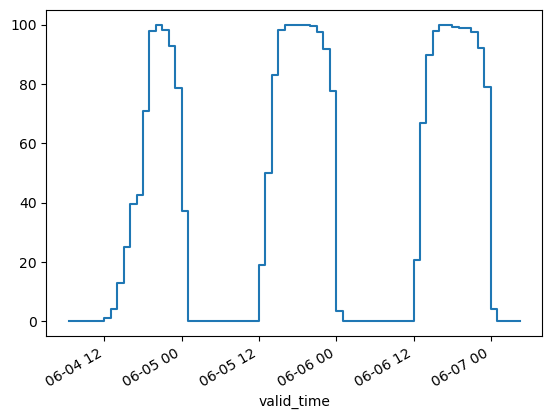

In [8]:
power_fcasts_gfs, _ = model_pv_power(resource_data_gfs, **plant_data)
power_fcasts_gfs.plot(drawstyle='steps-mid')

Convert to local time and calculate daily totals:

<Axes: xlabel='valid_time'>

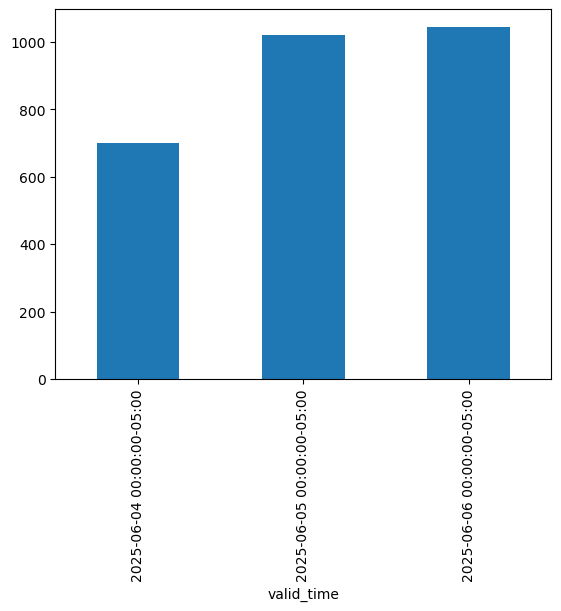

In [9]:
power_fcasts_gfs = power_fcasts_gfs.tz_convert('US/Central')
power_fcasts_gfs_daily = power_fcasts_gfs.resample('1d').sum()

power_fcasts_gfs_daily.plot(kind='bar')

And pick which day has the lowest energy, or at least let the forecast inform scheduling.

In [10]:
power_fcasts_gfs_daily

valid_time
2025-06-04 00:00:00-05:00     700.995650
2025-06-05 00:00:00-05:00    1020.094324
2025-06-06 00:00:00-05:00    1044.971119
Freq: D, dtype: float64

Follow the process outlined in [04_Make_Ensemble_Forecasts.ipynb](04_Make_Ensemble_Forecasts.ipynb) to make an ensemble forecast, and some of the steps in [05_Ensemble_Analysis.ipynb](05_Ensemble_Analysis.ipynb) to analyze it (but leaving out the `week` portion of the analysis). 

In [11]:
resource_data_ens = get_solar_forecast_ensemble(
        latitude=plant_data['latitude'],
        longitude=plant_data['longitude'],
        init_date=init_date,
        run_length=69, # just three days to let this example run faster
        lead_time_to_start=lead_time_to_start,
        model='ifs',
        attempts=4,
)

resource_data_ens['albedo'] = 0.2 # fill in albedo data

Model power:

In [12]:
member_list = resource_data_ens['member'].unique()
point_list = resource_data_ens['point'].unique()

# empty lists
ens_temp_list = []

for member in member_list:
    for plant_number in point_list:
        # pull plant data
        plant_data = agg_specs_orig_df[plant_number].to_dict()

        # get the resource forecast for the plant
        resource_fcast_ens = resource_data_ens[(resource_data_ens['point']==plant_number) \
            & (resource_data_ens['member']==member)]
        
        resource_fcast_ens = resource_fcast_ens.reset_index().set_index('valid_time')

        # model power
        power_fcasts_ens, _ = model_pv_power(resource_fcast_ens, **plant_data)

        power_fcasts_ens.name = 'power'

        # convert to dataframe and add 'point' (plant number)
        power_fcasts_ens = power_fcasts_ens.to_frame()
        power_fcasts_ens['point'] = plant_number
        power_fcasts_ens['member'] = member

        ens_temp_list.append(power_fcasts_ens)

power_fcasts_ens_all = pd.concat(ens_temp_list)

# convert to central time
power_fcasts_ens_all = power_fcasts_ens_all.tz_convert('Etc/GMT+5')

Calculate daily energy:

In [13]:
df = power_fcasts_ens_all.copy()

df = df.reset_index().set_index(['point', 'member', 'valid_time'])

df = df.groupby([pd.Grouper(level='point'),
                 pd.Grouper(level='member'), 
                 pd.Grouper(level='valid_time', freq='1D')]
               ).sum()
df = df.rename(columns={'power': 'daily_energy'})
df

daily_energy
point member valid_time                             
0     1      2025-06-04 00:00:00-05:00    325.640666
             2025-06-05 00:00:00-05:00    575.671015
             2025-06-06 00:00:00-05:00    795.397958
      2      2025-06-04 00:00:00-05:00    297.311306
             2025-06-05 00:00:00-05:00    646.768822
...                                              ...
      49     2025-06-05 00:00:00-05:00    740.439955
             2025-06-06 00:00:00-05:00    882.503596
      50     2025-06-04 00:00:00-05:00    190.648871
             2025-06-05 00:00:00-05:00    578.729772
             2025-06-06 00:00:00-05:00    960.265209

[150 rows x 1 columns]

Lowest day counts:

In [14]:
# unstack, group by point and week, find min index, re-stack, reset index
df_fcast = (df
		.unstack(level='member')
		.groupby(level=['point'])
		.idxmin()
		.stack(future_stack=True)
		.reset_index())


# The `daily_energy` column is a list of tuples, containing point, member,
# and day (with minimum energy). We can simply extract that column and turn
# it into a dataframe
df_fcast = pd.DataFrame(list(df_fcast['daily_energy']),
		columns=['point', 'valid_time'])

# then get value_counts()
# from https://note.nkmk.me/en/python-pandas-value-counts/
df_fcast = df_fcast.groupby(['point']).value_counts(dropna=False).to_frame()

df_fcast = df_fcast.rename(columns={'count': 'lowest_day_count'})

df_fcast

lowest_day_count
point valid_time                                 
0     2025-06-04 00:00:00-05:00                37
      2025-06-05 00:00:00-05:00                13

In [15]:
# fill in days with no counts, if needed
df_fcast = df_fcast.reset_index().set_index('valid_time')
days = df.reset_index()['valid_time'].unique()
df_fcast = df_fcast.reindex(index=days)
df_fcast

,point,lowest_day_count
valid_time,,
2025-06-04 00:00:00-05:00,0.0,37.0
2025-06-05 00:00:00-05:00,0.0,13.0
2025-06-06 00:00:00-05:00,NaN,NaN


And make a plot:

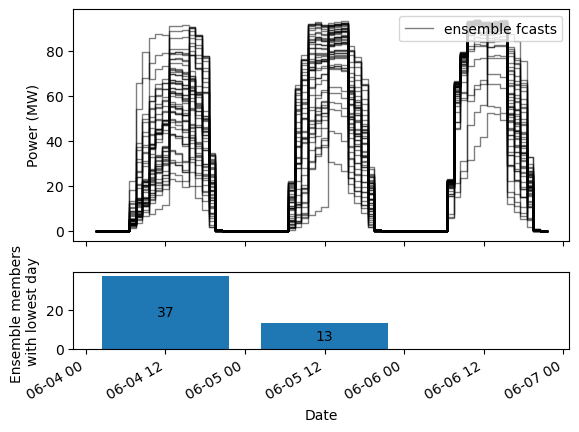

In [16]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(6.4, 5), height_ratios=[3, 1])

plant_number = 3
startidx=0
endidx=162

plant_number = 0
for member in member_list:
    df_temp = power_fcasts_ens_all[(power_fcasts_ens_all['member'] == member) & (power_fcasts_ens_all['point'] == plant_number)]['power']
    ax1.plot(df_temp.index, df_temp.values, label=('ens mem ' + str(member)), drawstyle='steps-pre', color='k', linewidth=1, alpha=0.5)

ax1.set_ylabel('Power (MW)')
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(['ensemble fcasts'], loc='upper right')

# second subplot
df_temp = df_fcast[df_fcast['point']==plant_number]['lowest_day_count']
df_temp.index = df_temp.index + pd.Timedelta('12h')
labels = df_temp.index.strftime('%Y-%m-%d')

p = ax2.bar(df_temp.index, df_temp.values)

# add labels
ax2.bar_label(p, label_type='center')

ax2.set_xlabel('Date')
ax2.set_ylabel('Ensemble members \nwith lowest day')

fig.autofmt_xdate()